In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import os, shutil
import torch
import time
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
import pdb
import matplotlib.pyplot as plt

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
import head
import numpy as np
from head.metrics import euclidean_dist
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.optim.optimize import optimize_acqf_discrete
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
from botorch.acquisition.objective import LinearMCObjective
from matplotlib.cm import ScalarMappable

N_UVVIS_SAMPLES = 10
N_SAS_SAMPLES = 100
NUM_GRID_PERDIM = 100
BATCH_SIZE = 5
N_ITERATIONS = 10
NUM_RESTARTS = 20 
RAW_SAMPLES = 1024


R_mu = 20
R_sigma = 1e-2
SHAPE_PARAM = 0.67
SPECTRA = 'uvvis'

expt = {}
EXPT_ID = 0

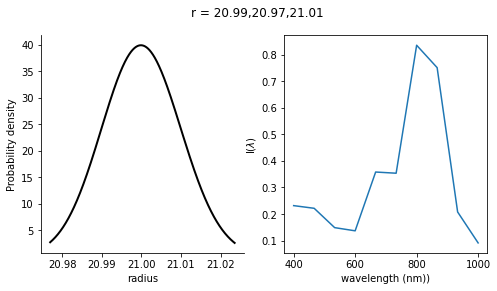

In [16]:
sim = head.EmulatorMultiShape()
sim.make_structure(r_mu=R_mu,r_sigma=R_sigma)

fig, axs = plt.subplots(1,2,figsize=(4*2,4))

sim.plot_radii(axs[0])
axs[0].set_xlabel('radius')
axs[0].set_ylabel('Probability density')

if SPECTRA=='saxs':
    xt, yt = sim.get_saxs(shape_param = SHAPE_PARAM, n_samples=N_SAS_SAMPLES)
    axs[1].loglog(xt, yt)
    plt.setp(axs[1], xlabel='q (1/A)', ylabel='I(q)')
elif SPECTRA=='uvvis':
    xt, yt = sim.get_uvvis(shape_param = 0.67, n_samples=N_UVVIS_SAMPLES)
    axs[1].plot(xt, yt)
    plt.setp(axs[1], xlabel='wavelength (nm))', ylabel=r'I($\lambda$)')
    
fig.suptitle('r = '+','.join('%.2f'%i for i in sim.radii))
plt.show()

In [17]:
# define search space
r_mu = [5,50]
r_sigma = [0,1]
shape_param = [0,1]
bounds = torch.tensor((r_mu, r_sigma, shape_param)).T.to(**tkwargs)

In [20]:
def oracle(x):
    """Scoring function at a given input location
    Uses the simulator sim to generate response spectra at a given locations
    and return a similarity score to target spectra
    """
    global EXPT_ID
    x_np = x.cpu().numpy()    
    sim.make_structure(r_mu=x_np[0],r_sigma=x_np[1])
    if SPECTRA=='saxs':
        xi, yi = sim.get_saxs(shape_param = SHAPE_PARAM, n_samples=N_SAS_SAMPLES)
        dist = euclidean_dist(np.log10(yi),np.log10(yt))
    elif SPECTRA=='uvvis':
        xi, yi = sim.get_uvvis(shape_param = 0.67, n_samples=N_UVVIS_SAMPLES)
        dist = euclidean_dist(yi,yt)
        
    expt[EXPT_ID] = [xi, yi, dist]
    EXPT_ID += 1
    
    return torch.tensor([dist])

def batch_oracle(x):
    out = []
    for xi in x.squeeze(1):
        out.append(oracle(xi))
    return torch.stack(out, dim=0).to(**tkwargs)

In [21]:
from botorch.utils.sampling import draw_sobol_samples

def draw_random_batch(n_samples=6):
    train_x = draw_sobol_samples(
        bounds=bounds,n=1, q=n_samples, 
        seed=torch.randint(2021, (1,)).item()
    ).squeeze(0)
    train_obj = batch_oracle(train_x)
    return train_x, train_obj

N_INIT_SAMPLES = 10
train_x, train_obj = draw_random_batch(n=N_INIT_SAMPLES)
print('Generated %d samples randomly'%N_INIT_SAMPLES, train_x.shape, train_obj.shape)
for i in range(N_INIT_SAMPLES):
    print('%d\t%s\t%s'%(i, train_x[i,...].numpy(), train_obj[i,...].numpy()))

NameError: name 'dist_sas' is not defined

In [7]:
def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, 
    outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

mll, model = initialize_model(train_x, train_obj)

# 3. Define acqusition function
obj = LinearMCObjective(weights=torch.tensor([1.0]).to(**tkwargs))


In [8]:
from botorch.optim.optimize import optimize_acqf

def selector(f, q = BATCH_SIZE):
    new_x, _ = optimize_acqf(
        acq_function=f,
        bounds=bounds,
        q=q,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES, 
        sequential=False,
    )
    new_obj = batch_oracle(new_x)
    return new_x, new_obj

In [9]:
torch.manual_seed(2021)
import pdb

# run N_ITERATIONS rounds of BayesOpt after the initial random batch
print('Sampled ID \t Locations \t Objectives')
for iteration in range(1, N_ITERATIONS + 1):    
    print('Iteration : %d/%d'%(iteration, N_ITERATIONS))
    # fit the models
    fit_gpytorch_model(mll)

    # define the acquisition module
    acquisition = qUpperConfidenceBound(model, beta=0.1, objective=obj)
    
    # optimize acquisition functions and get new observations
    new_x, new_obj = selector(acquisition)
    for i in range(BATCH_SIZE):
        print('%d\t%s\t%s'%(i, new_x[i,...].numpy(), new_obj[i,...].numpy()))

    # update training points
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])

    # re-initialize
    mll, model = initialize_model(train_x, train_obj)

    best = train_obj.max(axis=0).values
    print('Best %.2f'%(best))

Sampled ID 	 Locations 	 Objectives
Iteration : 1/10
0	[11.60255941  0.93117764  0.02612356]	[-7.95285559]
1	[14.19065914  0.02235781  0.86685165]	[-3.50849032]
2	[44.77867309  0.86676212  0.36888912]	[-5.0219512]
3	[35.55754887  0.27457397  0.06852533]	[-4.19122362]
4	[39.68252382  0.72648666  0.8678695 ]	[-5.03960562]
Best -3.51
Iteration : 2/10
0	[14.11761736  0.05481352  0.90204727]	[-3.55396557]
1	[9.2219026  0.622481   0.58227599]	[-5.77838945]
2	[1.42190802e+01 6.18427945e-04 9.39686878e-01]	[-3.50564194]
3	[40.49251245  0.44891781  0.94958201]	[-5.10001278]
4	[2.63398906e+01 2.55604262e-03 3.36493310e-01]	[-4.16072607]
Best -3.51
Iteration : 3/10
0	[37.94740013  0.24527581  0.77411423]	[-4.73953104]
1	[14.23148557  0.04419075  0.91004975]	[-3.49780321]
2	[25.30123291  0.71351599  0.72017266]	[-2.83646297]
3	[44.24937245  0.72652177  0.66018849]	[-5.59565973]
4	[14.29227895  0.12215272  0.91812202]	[-3.44737005]
Best -2.84
Iteration : 4/10
0	[16.5433333  0.7120487  0.5934008]	[-

In [10]:
# obtain best sample and corresponding objective
from botorch.acquisition import PosteriorMean
from botorch.acquisition.objective import ScalarizedObjective
objective = ScalarizedObjective(weights=torch.tensor([1.0]).to(**tkwargs))

print('Actual target : ', [R_mu, R_sigma])
opt_x, opt_obj = selector(PosteriorMean(model, objective=objective), q=1)
print('Optimal location: ',opt_x.numpy(),'\nOptimal model scores: ', opt_obj.numpy())

Actual target :  [20, 0.01]
Optimal location:  [[18.58914009  0.95800915  0.64071459]] 
Optimal model scores:  [[-1.44254732]]


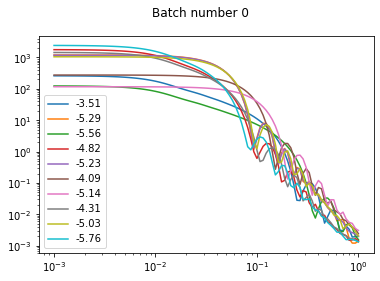

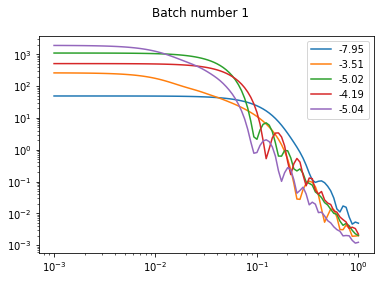

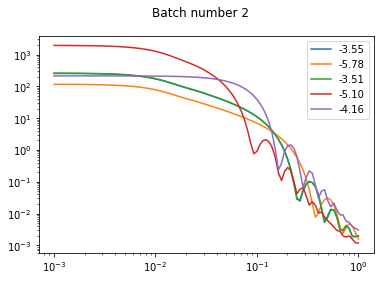

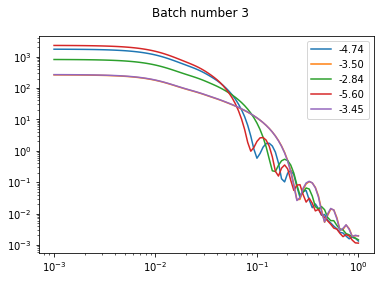

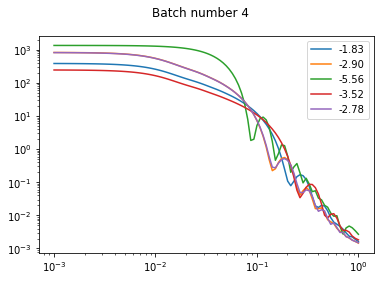

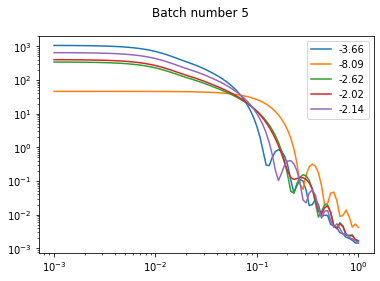

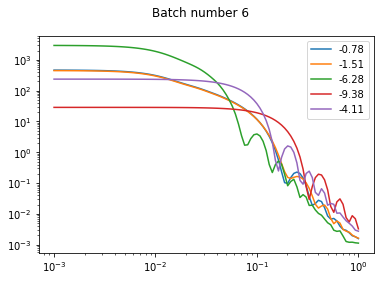

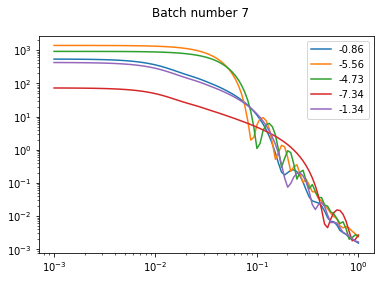

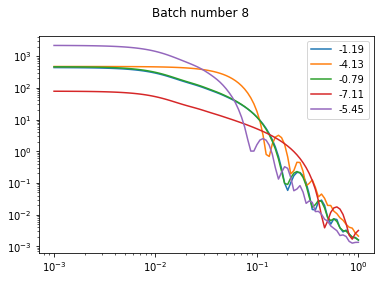

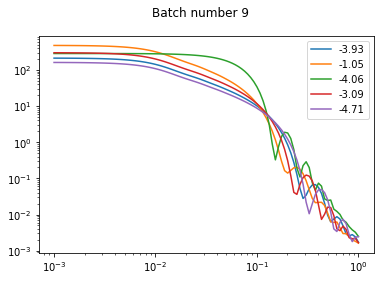

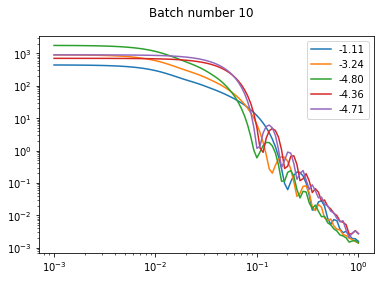

In [11]:
batch_number = torch.cat(
    [torch.zeros(N_INIT_SAMPLES), 
     torch.arange(1, N_ITERATIONS+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()

for b in np.unique(batch_number):
    fig, ax = plt.subplots(1,1)
    fig.suptitle('Batch number %d'%b)
    for i in np.argwhere(batch_number==b).squeeze():
        ax.loglog(expt[i][0], expt[i][1], label='%.2f'%expt[i][2])
    ax.legend()
    plt.show()